# PCA Statistical Arbitrage

(This notebook can be found on GitHub: https://github.com/rodler/quantinsti_statarb)

### Dr Tom Starke 

*Homepage: www.aaaquants.com *

*Email: tom@aaaquants.com *

*Linkedin: Dr Tom Starke *

What we will learn:
- Recap of pairs trading
- Revision of factor investing
- Pairs trading as a long/short factor strategy
- PCA
- "Drunk and her dog" cointegration
- Generalising cointegrated price series
- Backtesting PCA-based long/short portfolios
- Testing our models on recent datasets

Throughout the course we will see various practical examples for simple backtests that can help us to assess our strategy ideas quickly and efficiently. 
We will understand the opportunities and limitations of statistical arbitrage strategies and learn how PCA can be applied efficiently to this process. NOTE: WITH PCA WE USE PRICES, NOT RETURNS. WE TRANSFORM THE TIME SERIES TO MAKE THEM BE MEAN REVERTING>
Most of the course will use randomly generated time series with correlation and cointegration properties. For demonstration and understanding it is often better to start with synthetic series as they generally have well-understood properties.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib
from itertools import groupby, count
% matplotlib inline

## Factor Investing

In factor investing we aim to find time-dependent signals that are correlated to future returns. These factors could be:
- technical indicators (e.g. difference of two moving averages)
- fundamental factors (e.g. company data such as P/E ratio)
- macro factors (e.g. interest rates)
- abstract factors (e.g. PCA)

Today our main focus will be on abstract factors but before that we will have a look at factors in general. Once we have interesting factors, even if they are week, we can combine them to stronger factors. Throughout this seminar we will use synthetic price series, as we know understand their behaviour and we are able to tune them.

Let's first produce some random normally distributed numbers as a proxy for stock returns. We use random.seed() to create reproducible results.

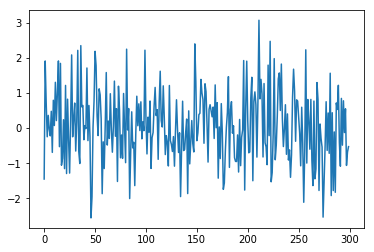

In [2]:
np.random.seed(200) # for reproducibility. if we change the number in seed, we get different result

# Let's create a series of returns
rets = np.random.randn(300) # create a series of 300 normally distributed returns
plt.plot(rets) # we end up with a stationary series, that mean reverts

Next, we create some factors. The easiest we to create a synthetic factor that we know has some predictive properties is to use the returns themselves and add noise to it (another random series with a 5 stdev). Here, we have four factors, the returns to which we add the same amount of noise:

In [3]:
np.random.seed(12)
sig = 5
F1 = rets + np.random.randn(300) * sig
F2 = rets + np.random.randn(300) * sig
F3 = rets + np.random.randn(300) * sig
F4 = rets + np.random.randn(300) * sig

Any one of these factors now is not very predictive. Now, we calculate the information coefficient for a single and for the combined factors, which is expressed by the Spearman rank correlation (instead of using actual values like in linear correlation, we use their ranks, and by doing so we get can get information when we don't know whether our factors are independent.
Now, we can see that the information coefficient increases as we add more factors. In isolation, these factors are weak, but in conjunction these factors are strong
We can add, multiply, do a PCA on the factors, many methods. Here we add them and we get a much better correlation coef

In [4]:
print(stats.spearmanr(rets,F1))
print(stats.spearmanr(rets,F1+F2))
print(stats.spearmanr(rets,F1+F2+F3))
print(stats.spearmanr(rets,F1+F2+F3+F4))

SpearmanrResult(correlation=0.17573661929576995, pvalue=0.002250980979079896)
SpearmanrResult(correlation=0.2863200702230025, pvalue=4.5468856473927663e-07)
SpearmanrResult(correlation=0.3546870520783564, pvalue=2.540263335697325e-10)
SpearmanrResult(correlation=0.398736874854165, pvalue=7.107573874243381e-13)


Let's visualise the improvement in correlation between a single and the combined factor:

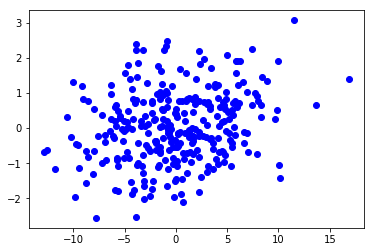

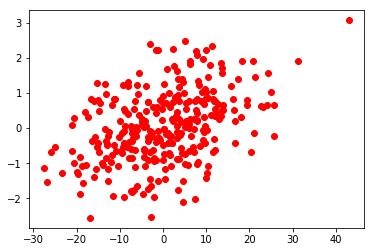

In [7]:
plt.plot(F4,rets,'bo');
plt.show()
plt.plot(F1+F2+F3+F4,rets,'ro');

Another way to assess the quality of our factors is to run a simple backtest. Since our factor is based on the return, we simply multiply the sign of our factor with the return in price, effectively creating a long/short strategy that rebalances every period. We then calculate the cumulative returns using np.cumsum() as it gives us a more realistic understanding of the strategy behaviour. This gives cumulative non compounded returs. If we wanted compounded return equity curves, we'd use cumulative product, not sum. It s usually better to look at non-compounded returs to reduce the swings and be able to assess the quality of the strategy. I guess we'd use compounded returns when looking at the money management part. 
The blue curves are our single factors and the performance of the strategy increases as we combine more of them.

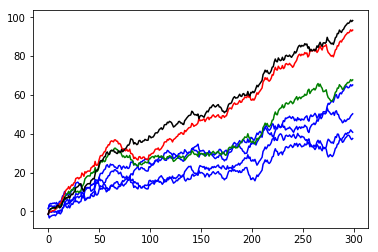

In [8]:
plt.plot(np.cumsum(rets * np.sign(F1)),'b');
plt.plot(np.cumsum(rets * np.sign(F2)),'b');
plt.plot(np.cumsum(rets * np.sign(F3)),'b');
plt.plot(np.cumsum(rets * np.sign(F4)),'b');
plt.plot(np.cumsum(rets * np.sign(F1+F2)),'g');
plt.plot(np.cumsum(rets * np.sign(F1+F2+F3)),'r');
plt.plot(np.cumsum(rets * np.sign(F1+F2+F3+F4)),'k');

For those intested in how to compute the cumulative return, have a look below. You can see a factor of 0.1 added, which is the fraction of our bankroll invested in that strategy. As an exercise, please change that factor and observe the change of your pnl curve. This simple example already shows how important it is to manage your portfolio correctly as re-investing can make a strategy extremely volatile. For deeper insight please have a look at Ed Thorp's paper on the Kelly formula: 
https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwie5oKZq6DeAhVKO48KHcU3Dy8QFjAAegQICRAC&url=http%3A%2F%2Fwww.eecs.harvard.edu%2Fcs286r%2Fcourses%2Ffall12%2Fpapers%2FThorpe_KellyCriterion2007.pdf&usg=AOvVaw0AHC_tkwpwLy38LF4JNgBQ

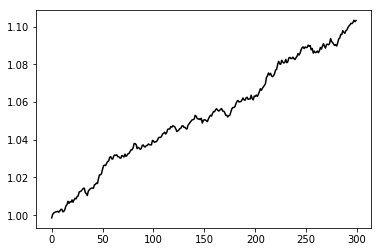

In [12]:
plt.plot(np.cumprod(1+0.001*(rets * np.sign(F1+F2+F3+F4))),'k');

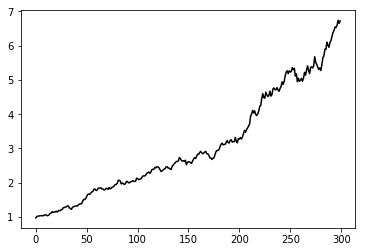

In [14]:
plt.plot(np.cumprod(1+0.02*(rets * np.sign(F1+F2+F3+F4))),'k');

## Pairs trading as factor investing

Let's first recap the idea of pairs trading as a form of factor investing before we generalise the process to portfolios of large numbers of instruments using Principle Component Analysis (PCA).
One condition neccessary for the success of pairs trading strategies is the existence of long-range causality also know as cointegration. We can understand this as a lagged-correlation relationship between different pairs of securities. If the residual price series is stationary, we can make predictions about its future direction. 

It is also possible to trade single stationary series (which are very rare in the markets these days), but the advantage of a pair is that we can create a portfolio that is cash-neutral and to some extend market-neutral.

Cash neutrality is easy to understand, you buy x dollars of share A and sell x dollars of share B. The only cash you need is the margin requirement of your short position. Assuming you have a long-only position your exposure would be $100 and the cost of your portfolio would also be $100. With a long/short pair the cost of your portfolio would be your margin (say $30) and the exposure $200. Overall, you can achieve significant leverage with this method.

Market neutrality is achieved through the fact that both securities A and B have a correlation with the market (beta), such that if the market makes a strong move the net effect on our portfolio will be negligible. However, for this, both betas for A and B need to be similar, otherwise we will not be exactly market-neutral. This can be achieved by creating portfolios with similar securities (e.g. Pepsi and Coca Cola) or by bulding larger portfolios where the fluctuations of beta amount to a similar average on the long and the short side.

### Cointegration versus correlation

Cointegrated price series do not necessarily have to be correlated and vice-versa as correlation just describes the momentary state whilst cointegration deals with longer-range causal relationships and this is what we can use for trading.

A good way to understand this is the example of the drunk and her dog:
https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction
where a drunk performs a random walk through the park and her dog is constantly running around her. In the case that the dog runs free we have a one-way causality from the drunk to the dog. However, with the dog on a leash, there might also be a causality from the dog to the drunk as the dog as he might pull her in a certain direction sometimes. Imagine the dog was the size of an elephant, the causality might reverse entirely.

We can see the same behaviour in the markets and causality relationships change. For more information please refer to Engle-Granger causality (https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjcvKPcsqDeAhXTbCsKHTmNAe8QFjAAegQIBxAB&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FGranger_causality&usg=AOvVaw1mYq3HhcjsVNJ9zJ6zgqdV)

Let's produce a cointegrated pair:

In [15]:
def make_coint_0(N,T0=[0,0],sigma=[1,1],c=[0.1,0.1]):
    X = [0]
    Y = [0]
    for i in range(N):
        rx = np.random.randn()*sigma[0] - c[0]*X[-1] - c[0]*Y[-1]
        ry = np.random.randn()*sigma[1] + c[1]*X[-1] - c[1]*Y[-1]
        X.append(X[-1]+rx)
        Y.append(Y[-1]+ry)
    return np.array(X)+T0[0],np.array(Y)+T0[1]

np.random.seed(452)
X,Y = make_coint_0(200)

The factor c above denotes the causality relationships between the two series. T0 is the starting value and sigma the volatility of each series. We can test the two series for cointegration. The three critical values denote the 1%, 5% and 10% levels for the test statistic v. In the case below, we have a less than 1% probability that our series are not cointegrated (because the v is below the first test statistic) whilst their correlation is very low. We can reject the null hypothesis that the 2 series are not cointegrated. However we can see the correlation plot shows no correlation

Critical values: [-3.95203768 -3.36685108 -3.065724  ]
Test statistic: -5.192355018742084
Correlation 0.03872917127875766


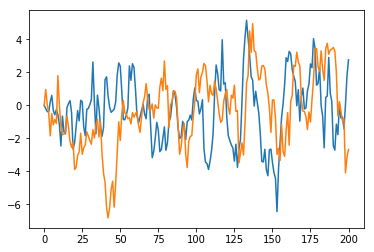

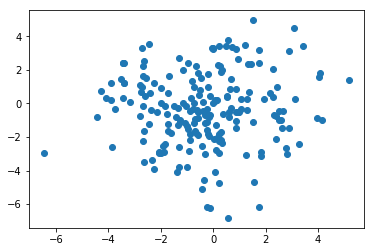

In [16]:
v, p_val, crit = coint(X,Y)
print('Critical values:',crit)
print('Test statistic:',v)
print('Correlation',np.corrcoef(X,Y)[1,0])

plt.plot(X,'-',Y,'-')
plt.show()
plt.plot(X,Y,'o')

### Backtesting our long/short pairs portfolio

Throughout this workshop you will see a series of different types of backtests to get a sense of different flavour on how to test a strategy for research from simple to more complex. 

In the backtest below, we deviate from the traditional pairs trading approach and assume that exit our position N periods after entering. For that, we could find the half-life of the mean reversion by fitting an Ornstein-Uhlenback process (more info here: https://mathtopics.wordpress.com/2013/01/07/ornstein-uhlenbeck-process/ and here: http://www.pythonforfinance.net/2016/05/09/python-backtesting-mean-reversion-part-2/).
In the case below we could simply can play with the parameters.

Note, that in our example below we compute a pnl for every instance where our factor is above or below the threshold. This will give an inflated pnl value but the advantage is that the test is not path-dependent, which can sometimes lead to unstable results when your holding periods are variable. If we were to ignore all the information between the entry signal and exit time, then the backtest would be extremely sensitive to entry time (path dependency). SO THIS BACKTEST DOESNT GIVE US A REAL P&L SINCE ENTRIES ARE CONTINUOUS UNTIL THE ENTRY SIGNAL IS FALSE, BUT GIVES US A TENDENCY ON THE PROFITABILITY OR NOT. THIS IS VERY USEFUL TO ASSESS HOW GOOD OUR FACTORS ARE IN THE BACKTEST

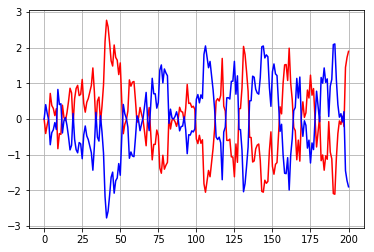

In [17]:
# Substract the 2 time series from each other to build a stationary time series 
# Our factor is simply the z-scored difference between the two series. The signal is when the z-score is above some arbitrary value
# usually we also compute the hedge ration - how much of one equity vs the other

def myFactor(X,other):
    return np.subtract(X,other)

def Zscore(X):
    return np.array((X - np.mean(X)) / np.std(X))

Fx = myFactor(X,Y)
Fy = myFactor(Y,X)

plt.plot(Zscore(Fx),'r-',Zscore(Fy),'b-')
plt.grid()

In [19]:
#now the backtest

lkfwd = 5 # 5 periods in the future
threshold = 2 #
pnl = 0

# separate equities into x and y and trade the longs and shorts differently

# Short Entry: pnl = entry_price-exit_price
idx1 = np.where(Zscore(Fx)>threshold)
pnl += (np.sum(X[idx1]-X[[n+lkfwd for n in idx1]]))

idx2 = np.where(Zscore(Fy)>threshold)
pnl += (np.sum(Y[idx2]-Y[[n+lkfwd for n in idx2]]))

# Long Entry: pnl = exit_price-entry_price
idx3 = np.where(Zscore(Fx)<-threshold)
pnl += (np.sum(-X[idx3]+X[[n+lkfwd for n in idx3]]))

idx4 = np.where(Zscore(Fy)<-threshold)
pnl += (np.sum(-Y[idx4]+Y[[n+lkfwd for n in idx4]]))

print('Strategy PnL:',pnl)

Strategy PnL: 42.982865816609184


C:\Users\Greg\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Greg\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\Greg\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `

In [20]:
# we can check our entry levels for each combibation of long/short and stock and find them on the plot above, example:
print (idx1)

(array([ 40,  41,  42,  43,  46, 131], dtype=int64),)


### Basic Factor-Based Portfolio Composition

Now that we've build and tested our portfolio pair let's look how we can create larger portfolios. The best known method is called the mean-variance portfolio (here: https://blog.quantopian.com/markowitz-portfolio-optimization-2/) where we can use our factors as input for the expected return rather than using the average return over the last N periods, which is not predictive. As this technique is beyond the scope of this presentation, we have a look at a simpler but often just as effective portfolio construction method. This method has two steps:

1) Weight the factors according to their information coefficient 

2) Assign portfolio weights according to the IC-weighted factors (see formula below)

We can do 100% exposure on the long side, 100% on the short side, for total exposure of 200% in a cash neutral portfolio.


The method below if for our long/short portfolios. We pick some of the factor values from above at time, and weight them with their IC. Then we use the formula:

\begin{align}
w_i = \frac{2(F_i - \bar{F})}{\sum_i{|F_i - \bar{F}|}}
\end{align}
Weight ~ (factor minus mean of factor values) divided by sum of that. So the weights all add up to 0 and we get a cash neutral portfolio
THIS WEIGHT IS RECALCULATED AT EVERY PERIOD

In [42]:
# Calculating the information coefficients and putting them into a list
ic = []
ic.append(stats.spearmanr(rets,F1)[0])
ic.append(stats.spearmanr(rets,F2)[0])
ic.append(stats.spearmanr(rets,F3)[0])
ic.append(stats.spearmanr(rets,F4)[0])

print (ic[0])

0.17573661929576995


In [34]:
enumerate?

In [33]:
# normalize the factors based on their information coef. NOT SURE WHY WE USE VALUE #120
ix = 120
F = [F1[ix],F2[ix],F3[ix],F4[ix]]
ic_weighted_F = np.multiply(F,ic)/np.sum(ic) 

# then calculate the portfolio weights with formula we saw above. NOT SURE WHY WE USE F INSTEAD OF IC_WEIGHTED_F
portfolio_weights = [2*(F[i]-np.mean(F))/np.sum(np.abs(F-np.mean(F))) for i,j in enumerate(ic_weighted_F)]
print('Portfolio weights:',portfolio_weights)
print('Sum of weigths:',sum(portfolio_weights))

Portfolio weights: [0.780768146636177, -0.9999999999999999, 0.13341415241924798, 0.085817700944575]
Sum of weigths: 8.326672684688674e-17


In [43]:
print (ic)
print (F)
print(ic_weighted_F)
enumerate(ic_weighted_F)

[0.17573661929576995, 0.23723019144657162, 0.23317414637940417, 0.2054573939710441]
[7.399258702120076, -5.764207149115782, 2.6140079031138064, 2.262174193144112]
[ 1.52691783 -1.60573816  0.71573537  0.54577421]


We get the weights, with only one on the short side, and total weight of 0, so the portfolio is cash neutral. Portfolio is not necessarily beta neutral, that would depend on the asset selection

## Principle Component Analysis (PCA) to construct abstract factors
https://systematicedge.wordpress.com/2013/06/02/principal-component-analysis-in-portfolio-management/

As mentioned above, factor investing can be done using a variety of factor types, here we will discuss the use of so-called "abstract factors". Such factors are purely mathematical and do not have a direct economic rationale such as, for example, fundamental factors, but they can be related to economic factors. For example, if we created abstract factors for the top-500 market cap companies in the US, one abstract factor derived from PCA would closely track the SPX index.

Let create some abstract factors. First, we create an array from our cointegrated pair X and Y where the values are centered around their mean.

In [47]:
np.random.seed(20)
x = np.random.randn(200)
y = x*2 + np.random.randn(200)
R = np.array([x-np.mean(x),y-np.mean(y)]) # here the mean is already 0, but with real price time series we'd need to do that

Next, we calculate its covariance matrix and subsequently the eigenvectors and eigenvalues. Here, the eigenvectors tell us the axis (DIRECTION) of the largest variance and the eigenvalues tell us the MAGNITUDE of the variance along each axis. Note that eigenvectors are always perpendicular to each other. So we look for the largest variance and in what direction. Similar to linear regression but not the same. People use PCA instead of LR because in LR, when we swap x and y, we get a different beta. In PCA, we get the same slope of the first principal component (eigen vector) -> more stable way to calculate beta

In [48]:
S = np.cov(R)
print(S)
EIG = np.linalg.eig(S)
print('Eigenvalues: ',EIG[0])
print('Eigenvectors: ',EIG[1])

[[1.08564898 2.11283705]
 [2.11283705 5.01643346]]
Eigenvalues:  [0.16541355 5.93666889]
Eigenvectors:  [[-0.91681431 -0.39931381]
 [ 0.39931381 -0.91681431]]


we can see that eigen values ar close to the variances of each time series
We get as many eigen orthogonal vectors as we have time series, and it gets pretty complex to work in high multidemension

Now we create the vectors in space and plot our x and y values. We can see that we are capturing the direction of the largest variance. These vectors are called principle components.

In [50]:
EV = EIG[1]
xx = np.linspace(min(R[0,:]),max(R[0,:]),200)
yy1 = (EV[0][0]/EV[0][1])*xx
yy2 = (EV[1][0]/EV[1][1])*xx

In [51]:
most_significant_factor = np.argmax(EIG[0])
print('Most significant factor: ',most_significant_factor)

Most significant factor:  1


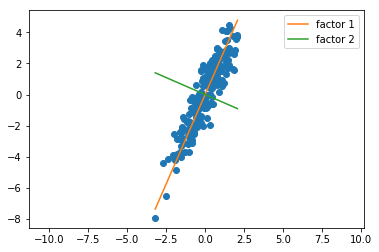

In [52]:
plt.plot(x-np.mean(x),y-np.mean(y),'o')
plt.plot(xx,yy1,label='factor 1')
plt.plot(xx,yy2,label='factor 2')
plt.legend()
plt.axis('equal');

In practice, we'll have to reduce the dimensionality of the factors, for instance here from 2 to 1, so that when we reverse transfor into returns we don't end up with the exact same time series, ie we need a system that's tradeable, not overfitted

We can see that for a series with two constituents we can create exactly two principle components. With the priciple components we can now calculate our abstract factors:

In [58]:
# Calculating the factor values from the eigenvector. 
#We here we produce our factors via reverse-transform, which is the dot product of the eigen vector with the R 
#(we didnt reduce the dimensionality here)
factors = np.dot(EV.T,R)

The plot below shows how well our factors are correlated with our returns. Note that for each return curve we have two factors.
We can see that whilst one of the factors has a strong correlation, the other does not.

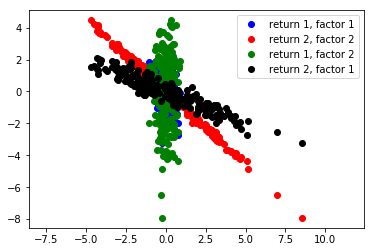

In [54]:
# Correlations between factors
plt.plot(factors[0],R[0,:],'bo',label='return 1, factor 1')
plt.plot(factors[1],R[1,:],'ro',label='return 2, factor 2')
plt.plot(factors[0],R[1,:],'go',label='return 1, factor 2')
plt.plot(factors[1],R[0,:],'ko',label='return 2, factor 1')
plt.axis('equal')
plt.legend();

## PCA Pairs Trade

In the next step we will see how to use PCA for pairs trading and then generalise the technique to large portfolios.

To start with let's produce another cointegrated pair:

In [ ]:
np.random.seed(452)
X,Y = make_coint_0(200,T0=[50,50])
print(coint(X,Y))
plt.plot(X,'r-',Y,'b-');

Next, we use the sklearn PCA package to do the analysis for us (we did it by hand before above). Once we produced the factors we run a linear regression with the price data and return the residuals. We trade when the price deviates sufficiently from the residuals. 
For pairs trading we only use the most significant factor. If we used both factors the residuals would be extremely small and the results would not make sense as we are only dealing with spurious fluctuations. 
In this example

In [59]:
def run_pca(pr,components=1,log_prices=True):
    
    # Instanciate PCA 
    pca = PCA(n_components=components)
    
    if log_prices: #log prices are nice for stat arb work, in particular when there is a large difference in price between the 2 stocks
        
        # Calculate the priciple components using log prices, this is the vectors
        comps = pca.fit(np.log(pr.T)).components_.T
    else:
        
        # Calculate the N priciple components using normal prices
        comps = pca.fit(pr.T).components_.T
        
    # Create the factors from the pricinple components, this is the reverse transform
    factors = sm.add_constant(pr.T.dot(comps))
    
    #this is linear regression fit vs prices and see how far our prices are away from our abstract factors and we look for mean reversion

    # Regress the factors with the actual prices 
    mm = [sm.OLS(s.T, factors).fit() for s in pr]
    
    # Calculate the residuals
    resids = list(map(lambda x: x.resid, mm))
    
    return resids, factors

In [62]:
R = np.array([X,Y])
residuals, factors = run_pca(R,log_prices=False) # USING LOG PRICES CAUSES AND DIV#0 ERROR, BUT GRAPHS BELOW LOOK THE SAME

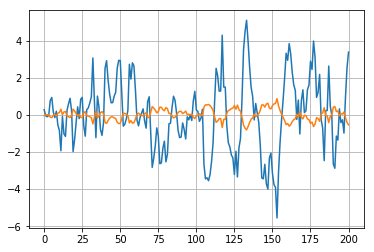

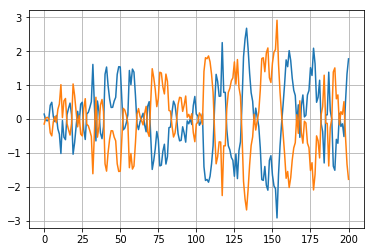

In [63]:
plt.plot(residuals[0])
plt.plot(residuals[1])
plt.grid()
plt.show()
plt.plot(Zscore(residuals[0]))
plt.plot(Zscore(residuals[1]))
plt.grid()

Below we can see another backtest. This time it sequentially steps through time and also through the instruments. This one is not a path independent / vectorized backtest as above. This one instead uses 2 loops, so it is slower, but we can make a more complex system and manage the portfolio



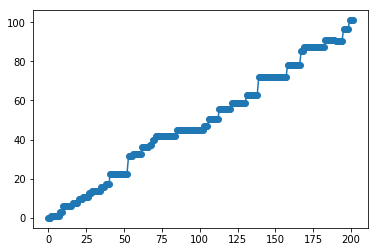

In [69]:
inpos = np.zeros(R.shape[0])
pnl = [0]
bw = .1
op = {}
entry = {}
for i in range(len(residuals[0])):
    p = 0
    for inst in range(R.shape[0]):
        zs = Zscore(residuals[inst])[i] # take our residuals (distance of price from vector expressed in standard deviation)
        if np.abs(zs)>bw and inpos[inst] == 0: #if we have a signal and we are not already in a position
            op[inst] = R[inst,i] # the opening price for this particular instrument is the R of instrument at time i
            inpos[inst] = zs # here we say that we are in a position. We store our z-score cuz it has a sign and informs whether is this a long or short position
            entry[inst] = i #it s helpful to save the entry time
        elif zs*np.sign(inpos[inst])<0 and inpos[inst]: # if the zs has changed sign and we are in a position
            p+=((-R[inst,i]+op[inst])*np.sign(inpos[inst])) # substract our exit from our entry and multiply by sign of position (neg for long, pos fo short)
            inpos[inst] = 0 #reinitialize the position value to 0
            
    pnl.append(p)
plt.plot(np.cumsum(pnl),'-o')
plt.show()

So we can see that the back test work with simulated time series data that we understand. It's doing what's expected. Then we will use it on real time series, which will unlikely to be as good

## Long/Short portfolio backtest



In order to simulate time series which resemble real equity behaviour more closely it is not enough to produce correlated and auto-correlated series. We also need a degree of cointegration in our system. This is also important for our strategies to work. However, we will see later, that this behaviour is very common. 

Unfortunately, there does not seem to be much literature on this currently, so here is my personal algorithm to produce large sets of cointegrated series. It's a bit of linear algebra but written in code it does not look too challenging. 
Here we build a bunch of co-integrated time series that are all stationary with each other

\begin{align}
c_{ij} = \Bigg\{ 
\begin{split}
-a_{ij} \quad for \quad i \leq j \\ 
a_{ij} \quad for \quad i \geq j \\ 
-a_{ij} \quad for \quad i = j
\end{split}
\end{align}

\begin{align}
X_{t}^{(i)}-X_{t-1}^{(i)} = \sum_{j} c_{ij} X_{t-1}^{(j)} + \epsilon_{i} \quad with \quad a_{ij} \geq 0
\end{align}

Here, *X* denotes the time series, *c* is the causality matrix and *a* are the positive elements of the causality matrix. 
Note that the *a's* denote the relationships between different series. We can simply use random numbers to start with but as we increase the number of series, we will need to keep *a* small to avoid positive feedback scenarios. You can play with this by varying *a* and observing the results.

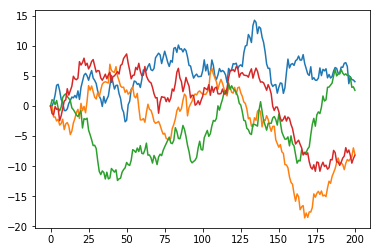

In [76]:
def make_coint_1(N,steps,a=0.1):
    X = [np.zeros(N)]
    
    # Create the causality matrix
    c = (np.tril(np.ones(N))-np.triu(np.ones(N))-np.diag(np.ones(N),0))*a #c = np.random.rand(N,N)*0.1

    # loop through time steps
    for i in range(steps):
        
        # Calculate the returns for each time series
        rx = (np.sum(c*X[-1],axis=1)+np.random.randn(N))
        
        # Add the new return to the last price of the time series
        X.append(X[-1]+rx)
        
    # return array of all series
    return np.array(X).T

np.random.seed(21)
X1 = make_coint_1(4,200,a=0.004).T  
#Be careful here, there is an internal feedback look that creates convergence/amplification. 
#Need to reduce the co-integration factor a - Play with it and see what happens

#plt.plot(X1[:,0],'r-',X1[:,1],'b-',X1[:,2],'g-',X1[:,3],'k-');
for i in range(4):
    plt.plot(X1[:, i])

We can see we have produced a set of stationary time series (fixed mean and stdv), testing for cointegration (pre-requisite of stationarity) we see that most of them are below the critical values.

In [77]:
print('Critical values:',coint(X1.T[0],X1.T[1])[2])
for i in range(X1.T.shape[0]):
    for k in range(i,X1.T.shape[0]):
        if not i==k:
            print('t-stats for coint of series %s and %s:'%(i,k), coint(X1.T[i],X1.T[k])[0])
        

Critical values: [-3.95203768 -3.36685108 -3.065724  ]
t-stats for coint of series 0 and 1: -2.7885578602684813
t-stats for coint of series 0 and 2: -2.781744056004618
t-stats for coint of series 0 and 3: -2.765859830165578
t-stats for coint of series 1 and 2: -1.3513360969415025
t-stats for coint of series 1 and 3: -3.0130198374228936
t-stats for coint of series 2 and 3: -2.5932596920939783


None of them above are statistically co-integrated at 90% confidence, but that's ok we can still work with it. We can make them more co-integrated if we change our co-integration factor a to something higher


With that, we can build a basic backtest that can help us get a sense if our portfolio strategy would be viable. In the backtest below we sort the z-scores of our factors and go long the lowest and short the N assets with the highest z-scores. in this back test we rebalance at every period, not when we reverse to the mean. Here instead of applying a threashold of the z-scores, we trade the most extreme ones

In [78]:
def backtest(pr,max_pos=2,num_factors=1,initial_cash=1e6):
    entry = {} # dictionary of entry prices
    pnls = []
    
    # Exit if we specified too large long/short position size
    if max_pos > pr.shape[0]/2:
        print('max_pos too large!')
        return

    # loop through the prices
    for i,pri in enumerate(pr.T):
        
        # Make sure you have enough data points
        if i < 50: continue
            
        # Run the PCA, only on the past prices
        resids, factors = run_pca(pr[:,:i],num_factors,log_prices=True)
        zs = {}
        
        # Calculate the z-scores for each instrument. 
        for inst in range(len(pri)):
            zs[inst] = Zscore(resids[inst])[-1] 

        pnl = 0
        # Calculate the Pnl for each position over the prevoius period
        for j,idx in enumerate(entry):
            
            # Calculate the position size
            pos = np.round((initial_cash/len(pri))/entry[idx])
            
            # Add up the pnls for all positions for the last period
            pnl += (pri[idx]-np.abs(entry[idx]))*pos
        pnls.append(pnl)
        
        # Reset the portfolio
        entry = {}
        
        # Find the new instruments to be traded based on their z-scores
        idx_long = (np.argsort([zs[j] for j in zs])[:max_pos])
        idx_short = (np.argsort([zs[j] for j in zs])[-max_pos:])
        
        # Add them to the entry list
        for idx in idx_long:
            entry[idx] = pri[idx]
        for idx in idx_short:
            entry[idx] = -pri[idx]
        
 
    return(pnls)
                            



### Long/Short Pair

Let's now apply our statistical arbitrage system to a simple long/short pair in order to test if our system is working properly. First, let's produce a cointegrated time series and plot it to confirm its properties.

In [79]:
np.random.seed(27)
N = 2
alpha = 0.1
X1 = make_coint_1(N,2000,a=np.random.rand(N,N)*alpha) + 50

(-9.327640870070335,
 1.2663353474547867e-14,
 array([-3.90192433, -3.33918676, -3.04657128]))

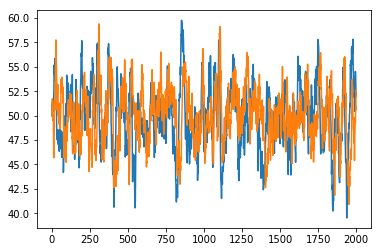

In [80]:
plt.plot(X1.T[:,0])
plt.plot(X1.T[:,1])
coint(X1.T[:,0],X1.T[:,1])

We can see from the plot and the numbers that the series is highly cointegrated, so we expect to see a very good result as shown below. Please run the same simulation with a less cointegrate series by lowering *alpha* to 0.01.

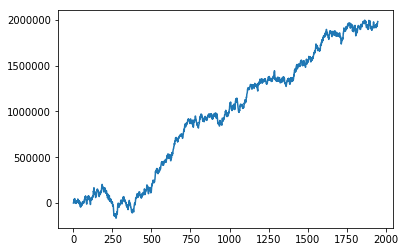

In [81]:
pnls = backtest(X1,max_pos=1,num_factors=1,initial_cash=1e6)
plt.plot(np.cumsum(pnls));

## PCA Portfolio Trading

Now that we have established that our statistical arbitrage system works for cointegrated pairs, let's look at applying it to larger portfolios. When we create larger sets of cointegrated series we have to be careful with the causality coefficients as large numbers of strong cross-dependencies can create positive feedback loops between the series. The large the number of series N, the higher to probability of the feedack loops for a given *alpha*.

In [82]:
np.random.seed(231)
N = 10
alpha = 0.06
X2 = make_coint_1(N,300,a=np.random.rand(N,N)*alpha) + 30

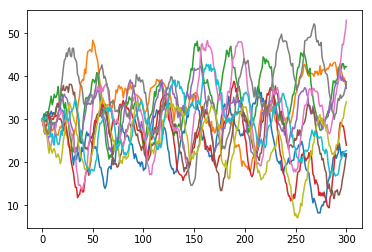

In [83]:
for i in X2:
    plt.plot(i)

Please vary alpha in this exercise and observe how the behaviour of our time series changes.

Next, let's have a look at the explanatory value of our priciple components. In the plot below we can see the cumulative explained variance for the components from the strongest to the weakest. Remember that building the factors is equivalent to dimensionality reduction and using all the factors would essentially replicate the original price series and all our residuals go towards zero. We could not use such a system for trading. To introduce more "slack" in the system it is often desirable to only use very few of the available priciple components. 

In the plot below we can see that 5 components already explain more than 90% of the variance of our system and for stat-arb to work we should stay well below that. In practice, here don't use more than the first 2 otherwise we really curve fit.

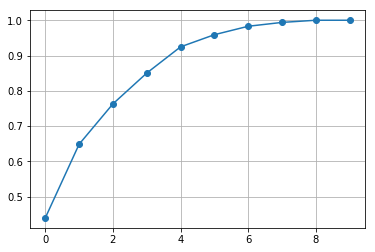

In [84]:
pca = PCA(n_components=10)
pca.fit(np.log(X2))
plt.plot(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_),'-o')
plt.grid()

From empirical observation we find it useful to look at the average t-statistics between all possible pairs and if that value is sufficiently large we have a much higher probability that our strategy will work. 

An advantage of the portfolio approach is that we do not have a strict requirement for cointegration of one specific pair. If, for example, we look at a specific sector, we have a much higher probability that a subset of our pairs will have high cointegration.

People who are familiar with cointegration might wonder why we do not use the Johansen test for larger portfolios. The reason is that this test provides a weighting for each constiuent that can easily create cointegration in-sample but it has empirically be shown multiple times that this results in a high degree of overfitting.

In [85]:
# Cointegration test:
coints = []
print('Critical values:',coint(X2[0],X2[1])[2])
for i in range(X2.shape[0]):
    for k in range(i,X2.shape[0]):
        if not i==k:
            coints.append(coint(X2[i],X2[k])[0])
            
print('Average coint t-stats:',np.mean(coints))

Critical values: [-3.93331886 -3.35657281 -3.05861756]
Average coint t-stats: -3.770255920121289


We can see in the backtest below that our strategy is profitable for this particular set of parameters we have chosen. Please play with the parameters of the cointegration engine as well as the backtest parameters to get a feel for how the system responds. 

Of course, this system is only a starting point and we can make numerous improvements that would markedly increase our performance. 

One notable improvement to the system would be to determine the half-life of the mean reversions we are looking at and rebalancing at less frequent intervals. This can be done using the Ornstein-Uhlenbeck model and it is an interesting exercise for you to try which is beyond the scope of this workshop. 

Another improvement would be to manage the position sizes with the factor based sizing as shown above. Ultimately, each market has it's own dynamics and there is no silver-bullet process that works.

Next, we have a look at the current US market and see if we can find some interesting opportunities in different industry sectors.

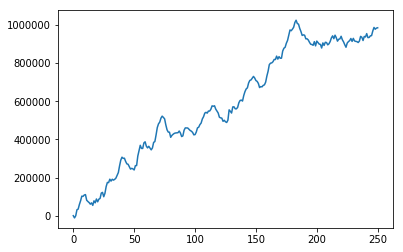

In [86]:
pnls = backtest(X2,max_pos=5,num_factors=1,initial_cash=1e6)
plt.plot(np.cumsum(pnls));
plt.show()

## Final Note

Some people debate if statistical arbitrage can be done on prices rather than returns. From a purely academic perspective, the case for returns is based on the assumption of a stationary series. However, dealing with cointegration effectively create synthetic stationary series. This technique has been successfully applied for decades, so please be sure to form your own educated opinion about its usefulness.
